# Third Hand Smoking Study 2017-19

### Sequencing was done by TSRI. The files given contain all the samples and barcodes. Next we need to remove barcodes and demultiplex our samples. I will run the barcode removal and demultiplexing step using qiime1 instead of Qiime2 since qiime2 method is kinda slow and buggy.

### Acquiring sequences from TSRI/ Illumina
You need to make an Illumina account to access the BaseSpace page.
Click on the given link to get access to the sequencing data and accept it.
Before downloading the sequences you need to install the downloader (BaseSpace Sequence Hub Downloader)

### Extracting barcodes
To do this, you need to have Qiime 1 installed. We will be extracting the barcodes and demultiplex the samples using Qiime1 instead of Qiime2 because it is running slow at the moment. 

### How to install Qiime1


### (Method 1) Installing MacQiime
MacQiime is the install method used to install Qiime1 for the mac
http://www.wernerlab.org/software/macqiime This is where you find the install of MacQiime
http://www.wernerlab.org/software/macqiime/macqiime-installation This is the page that tells you how to install it.
For installing, I also went through the steps in the section titled: Getting MacQIIME to work in El Capitan (OS 10.11). By doing this, you do not have to type in "source /macqiime/configs/bash_profile.txt" whenever you want to use these qiime1 tools.

### (Method 2) Installing Qiime1 (Version 1.9.1) thru conda [Recommended. it is way easier]
Qiime1 through conda installation is the easiest way to get it on your computer. 
If you already have conda installed, then the easiest way to get Qiime1 is do a simple install through a new environment made. Source activate it to use it. Test that it works with print_qiime script. http://qiime.org/install/install.html

conda create -n qiime1 python=2.7 qiime matplotlib=1.4.3 mock nose -c bioconda
source activate qiime1
print_qiime_config.py -t


### Setting up you metadata file (aka the mapping file)
When working with qiime2, you will have to work with a metadata file. This is a file that has information about the samples (sample id, phenotype, source, etc. ) You need to make sure that it is qiime2 compatible (and qiime1 compatible when you extract the barcodes using qiime1 python scripts). Refer to https://docs.qiime2.org/2018.6/tutorials/metadata/ for more information and an example. I recommened reformatting the metadata file through google sheets to take advantage of keemei. In the metadata file make sure you have a column called barcode, that is just the barcode sequence only (no primer sequence or linker sequence)

### Creating the barcode column in your metadata file
To do this, you need a column that has the full barcode + linker(CC) + primer sequence. This can be found in the original primer order form, but this should already be in your file. If you have this elongated sequence, you can simply perform a couple of functions on it to only get the barcode sequence. Make a new column and first use the substitute function to remove spaces in the elongated sequence. Next make a second column and then use the left function to only display the beginning of the string which is the barcode (12nt long).

### Extracing barcodes (Cont'd)
The following is entered through the terminal. 
Backward slashes are used so you do not have to enter everything on line in the terminal.
#### Before running the code, make a dedicated folder for holding everything (ie. pellet-removal-qiime-analysis). When you download the sequences, they will be in two gz files and within multiple folders. Simply move the gz files into the dedicated folder, this will just make it easier to work with. Also have the metadata file in that dedicated folder as well, to make things easier as well. 

In [2]:
#Title: Testing if Qiime1 is activated in our notebook
#Purpose: The purpose of this section is to simply see if qiime1 is activated in our jupyter notebook.
#Script: Print_qiime_config
!print_qiime_config.py -t 
    #The ! is so we can run terminal commands in the notebook
    #The -t is for running the test

#Information/ Results:
#Python version 3.7.1
#Qiime version 2.

/bin/sh: print_qiime_config.py: command not found


In [ ]:
# This is entered on the terminal (Remember to remove the ! when copying into the terminal)
# For this to work you have to have Qiime1 installed by now and activated
# After these commands, two things will be generated. reads.fastq and barcodes.fastq
!extract_barcodes.py -f ../illumina_sequences/PT-pool-2_S1_L001_R1_001.fastq.gz
    -c barcode_single_end \
    --bc1_len 12 \ #This is how long the barcode length is, until you reach the reverse primer linker (CC)
    -o emp-single-end-sequences \ #We are placing the output in this file
    -m exp12_metadata.tsv #This is the metadata file that we will use for everything. Make sure it is formatted correctly

#Double check the output, make sure that it is all good. 
#Make sure the barcodes look okay, they should be 12nt long.
#Make sure the reads look okay, they were cut at the reverse primer linker so they should start with CC
#Output will be
    #reads.fastq
    #barcodes.fastq

### Making Artifacts for Qiime2 (via Qiime2)
This is where you make the qza artifacts for the sequences thru a qiime tool called import. Before you do anything though, you need to have Qiime2 installed.

### Installing Qiime2
Refer to this page https://docs.qiime2.org/2018.6/install/native/#install-miniconda. This is extremely important!!!!
Make sure you install it thru miniconda, it is the most simplest way. 
#### Just remember to install Qiime2 as a seperate conda enviroment. AKA it is different from the regular conda environment whenever you intall miniconda for the first time. (Enter the commands: conda env list to see all of the environments you have installed. After installing you should have your base and the newly made qiime2-2018.6 ). If you do not install Qiime2 thru a new environment you can potentially mess up your base and you will have to install a brand new version of conda (after 100% deleting the old conda successfully). Always create environments when you are installing large programs like qiime2 which use many little programs.

In [ ]:
# first make sure your files are gziped, we will also rename the reads to sequences.fastq
!gzip emp-single-end-sequences/barcodes.fastq
!mv emp-single-end-sequences/reads.fastq emp-single-end-sequences/sequences.fastq
!gzip emp-single-end-sequences/sequences.fastq
#Output will be barcodes.fastq.gz and sequences.fastq.gz

#This is where we make the artifact from the sequences. Note they are still not demultiplex.
!qiime tools import \
  --type EMPSingleEndSequences \
  --input-path emp-single-end-sequences \
  --output-path emp-single-end-sequences.qza

### Demultiplexing Samples
This step takes some time to run (~30+ minutes).

In [ ]:
#This is the demultiplex step. Make sure metadata has a column called barcode that is just the 12nt barcode sequence
!qiime demux emp-single \
  --i-seqs emp-single-end-sequences.qza \
  --m-barcodes-file exp12_metadata.tsv \
  --m-barcodes-column barcode \
  --o-per-sample-sequences demux.qza

In [ ]:
#visualize demultiplexed samples. Turns artifact into visualization
!qiime demux summarize \
  --i-data demux.qza \
  --o-visualization demux.qzv
    
!qiime tools view demux.qzv #This allows you to visualize

### Sequence quality control and feature table construction using DADA2
The other alternative is thru deblur so make a folder called dada2 inside the dedicated folder in case you want to do deblur instead.

#### The dada2_o directory is so we can keep everything in there in case we need to do another analysis with another program (deblur)


In [ ]:
#This is where we actually do the sequence quality control.
#Since my quality was high in the beginning there was no need to trim the beginning
#Since the ending only really starts to drop off in quality at 260nt I decided to truncate at 240
#This is the longest step, it took me about 13 hours to run everything. 
#Specs: 2016 macbook pro 2.3 GHz Intel Core i5 with 8GB of RAM
!mkdir dada2_o
!qiime dada2 denoise-single \
  --i-demultiplexed-seqs demux.qza \
  --p-trim-left 0 \
  --p-trunc-len 240 \
  --o-representative-sequences dada2_o/rep-seqs-dada2.qza \
  --o-table dada2_o/table-dada2.qza \
  --o-denoising-stats dada2_o/stats-dada2.qza #This is the denoised statistics

In [ ]:
#this converts the stats into a visualization
!qiime metadata tabulate \
    --m-input-file dada2_o/stats-dada2.qza \
    --o-visualization dada2_o/stats-dada2.qzv
!qiime tools view dada2_o/stats-dada2.qzv

### Results of checking the denoised statistics
When running the denoised statistics, it shows basically how many reads were still kept after running dada2.
There are 5 columns (and it can be downloaded as tsv file).
Columns are: Sample id (1), input (2), filtered(3), denoised(4), nonchimeric (5)
The number of reads for each sample successively decreases with each column. 


### Feature table and feature data summaries
So earlier we just finished doing the sequence quality control filtering step. The following steps are visualizations so that we can get some information on our data before we do any hardcode analysis (like alpha diversity and the such).

A feature is essentially any unit of observation, e.g., an OTU, a sequence variant, a gene, a metabolite, etc, and a feature table is a matrix of sample X feature abundances (the number of times each feature was observed in each sample). You can think of them as OTUs, but depending on the type of program you used, they may be SVs instead or something else, like a gene or a metabolite.

The feature-table summarize gives info on how many sequences are associated with each sample and with each feature, histograms of those distributions, and some related summary statistics. 

The feature-table tabulate-seqs provides maps of feature IDs to actual DNA sequences, and provide links to BLAST each sequence against the NCBI nt database

#### The point of this step is a barebones look on our samples and sequences for doing some random blasting and low level observations. (not actual statistical analysis)

In [ ]:
# Summarizes number of sequences per sample and with each feature + histogram + other small things
!qiime feature-table summarize \
    --i-table dada2_o/table-dada2.qza \
    --o-visualization dada2_o/table-dada2.qzv
    --m-sample-metadata-file exp12_metadata.tsv #This was not needed so you can probably remove this part of the code

# Shows the actual nucleotide sequences so you can blast them
!qiime feature-table tabulate-seqs \
    --i-data dada2_o/rep-seqs-dada2.qza \
    --o-visualization dada2_o/rep-seqs-dada2.qzv

!qiime tools view dada2_o/table-dada2.qzv
!qiime tools view dada2_o/rep-seqs-dada2.qzv

### Taxonomic analysis (This is later in the tutorial, but Pedro had done it earlier)


In [ ]:
!qiime feature-classifier classify-sklearn \
    --i-classifier taxonomic_ananlysis/gg-13-8-99-515-806-nb-classifier.qza \
    --i-reads dada2_o/cohousing-rep-seqs.qza \
    --o-classification taxonomic_ananlysis/cohousing-taxonomy.qza
    
#visualize
qiime metadata tabulate \
    --m-input-file taxonomic_ananlysis/cohousing-taxonomy.qza \
    --o-visualization taxonomic_ananlysis/cohousing-taxonomy.qzv 
    
#barplot
!qiime taxa barplot \
    --i-table dada2_o/cohousing-table.qza \
    --i-taxonomy taxonomic_ananlysis/cohousing-taxonomy.qza \
    --m-metadata-file mapping_file_cohousing2018.tsv \
    --o-visualization taxonomic_ananlysis/taxa-bar-plots.qzv


### Generate tree for phylogenetic diversity analysis
We want to make a tree for doing some phylogenetic diversity analysis. This includes Faith’s Phylogenetic Diversity (alpha diversity) and weighted and unweighted UniFrac (Beta diversity). A lot of the later analysis require a tree in order to perform them.

In [ ]:
# Making a folder to hold our a phylogenetic data
!mkdir dada2_o/phylogenetic_tree

#This makes a multiple sequence alignment
!qiime alignment mafft \
    --i-sequences dada2_o/rep-seqs-dada2.qza \
    --o-alignment dada2_o/phylogenetic_tree/alinged-rep-seqs.qza

#This filters the MSA to remove positions that are highly variable because all they do is add extra noise.
!qiime alignment mask \
    --i-alignment dada2_o/phylogenetic_tree/alinged-rep-seqs.qza \
    --o-masked-alignment dada2_o/phylogenetic_tree/masked-aligned-rep-seqs.qza

#This actually creates an unrooted phylogenetic tree from this masked (aka denoised) MSA
!qiime phylogeny fasttree \
    --i-alignment dada2_o/phylogenetic_tree/masked-aligned-rep-seqs.qza \
    --o-tree dada2_o/phylogenetic_tree/unrooted-tree.qza

#This actually uses the unrooted phylogenetic tree to make a rooted tree
#They place the root of the tree at the midpoint of the longest tip-to-tip distance in the unrooted tree
!qiime phylogeny midpoint-root \
    --i-tree dada2_o/phylogenetic_tree/unrooted-tree.qza \
    --o-rooted-tree dada2_o/phylogenetic_tree/rooted-tree.qza

### Alpha and beta diversity analysis¶
They use the q2-diversity plug in.

### Core metric analysis (Pt 1 of Alpha and beta diversity analysis)
They are very basic diversity analysis.\
Sampling depth must be given in order to do these analysis. Typically you want these to be as high as possible. For the tutorial they used 1109 since that was the max before removing the second sample. 

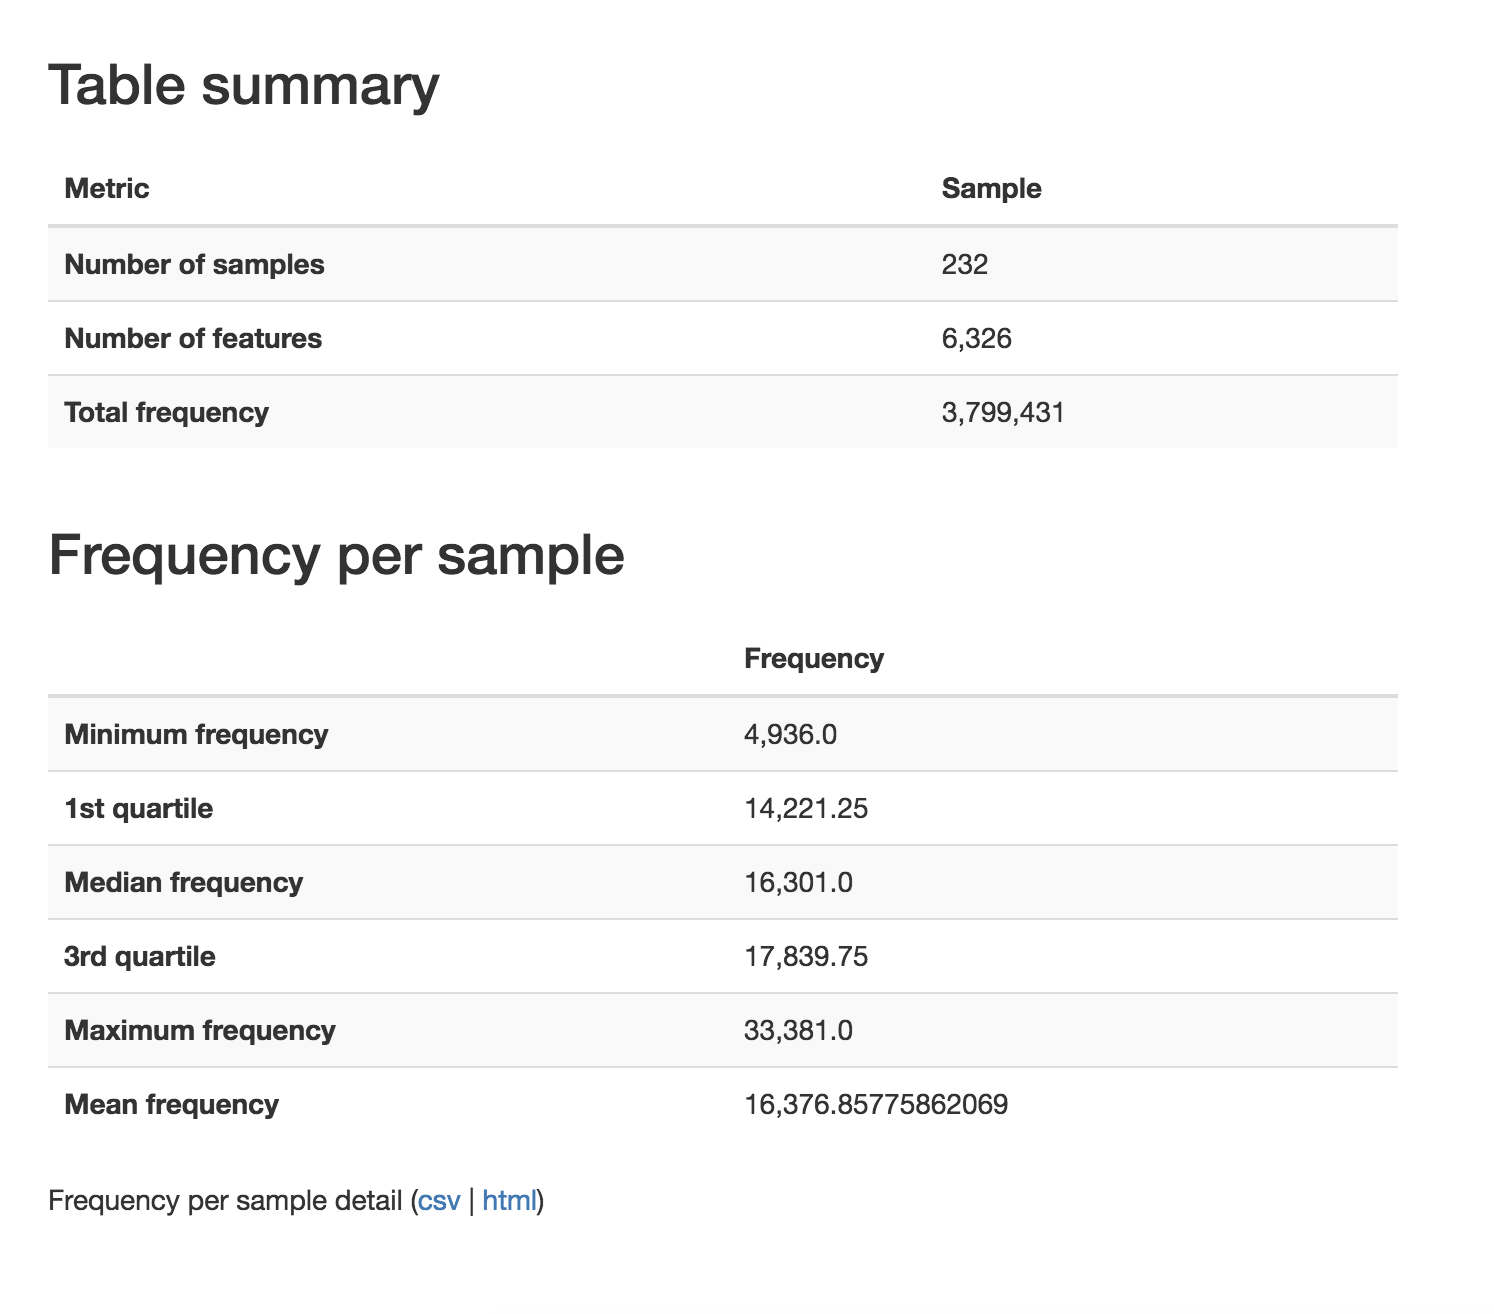

In [3]:
#This will be an image of the table to see 
import os
from IPython.display import Image
Image(filename='/Users/pabloarroyo/Desktop/pellet-removal-qiime2-analysis/table-image.png') 

Minimum frequency is 4936 which will include sample 344 T12 (Placebo). Next lowest frequency is 7455 for the PCR control. I will run core metrics using two different sampling depths one that will include 344.T12 and one without to see what difference, if any, it makes.

In [ ]:
#First you need to check your table.qsv visualization in order to determine the sampling depth that you will use.
!qiime tools view dada2_o/table-dada2.qzv

# Samping depth of 4936
!qiime diversity core-metrics-phylogenetic \
    --i-phylogeny dada2_o/phylogenetic_tree/rooted-tree.qza \
    --i-table dada2_o/table-dada2.qza  \
    --p-sampling-depth 1 \
    --m-metadata-file exp12_metadata.tsv \
    --output-dir core_metrics_4936
    


#### Performing the alpha group significance

In [ ]:
#This will do all alpha group significance tests on the four vectors in the core metrics file rather than doing them
#individually in the tutorial
#Faith's PD, Shannon, Observed OTUs, and evenness

#For the sampling depth of 4936 (includes all of the samples)
!for i in core_metrics_4936/*vector.qza ;
    do qiime diversity alpha-group-significance \
    --i-alpha-diversity $i \
    --m-metadata-file exp12_metadata.tsv \
    --o-visualization ${i%.qza}.qzv ; 
done

#For the sampling depth of 7455 (excludes the one sample 344.T12)
!for i in core_metrics_7455/*vector.qza ;
    do qiime diversity alpha-group-significance \
    --i-alpha-diversity $i \
    --m-metadata-file exp12_metadata.tsv \
    --o-visualization ${i%.qza}.qzv ; 
done

#For visualizing at 4936
!qiime tools view core_metrics_4936/evenness_vector.qzv
!qiime tools view core_metrics_4936/faith_pd_vector.qzv
!qiime tools view core_metrics_4936/observed_otus_vector.qzv
!qiime tools view core_metrics_4936/shannon_vector.qzv

!qiime tools view core_metrics_7455/evenness_vector.qzv
!qiime tools view core_metrics_7455/faith_pd_vector.qzv
!qiime tools view core_metrics_7455/observed_otus_vector.qzv
!qiime tools view core_metrics_7455/shannon_vector.qzv


#### At the moment we are skipping over the beta group differences.

#### But we will do the alpha rarefaction analysis

### Alpha rarefaction plotting¶
This explores the alpha diversity as a function of sampling depth. Has two parameters, min and maximum sampling depth. Maximum sampling depth is determined by view frequency per sample on the table.qzv

For determining the max depth, try to have it near medium frequency (Tutorial used 4000 and its median had 4139, retained 45% sequences in 18 samples). 

For my table-dada2.qzv file my median frequency was 16301, so probably will use 16000.

There will be two plots. The top plot is an alpha rarefaction plot, and is primarily used to determine if the richness of the samples has been fully observed or sequenced. 

If the slope of the top plot is 0 that means that collecting more sequences past the depth will not result in additional features. 

The bottome plot illustrates the number of samples that remain in each group when the feature table is rarefied to each sampling depth


In [ ]:
# alpha rarefaction plot 
# need to make a dedicated folder for containing alpha-rarefaction-plot/
!mkdir dada2_o/alpha-rarefaction-plot/

!qiime diversity alpha-rarefaction \
    --i-table dada2_o/table-dada2.qza \
    --i-phylogeny dada2_o/phylogenetic_tree/rooted-tree.qza \
    --p-max-depth 16000 \
    --m-metadata-file exp12_metadata.tsv \
    --o-visualization dada2_o/alpha-rarefaction-plot/alpha-rarefaction.qzv
    
qiime tools view dada2_o/alpha-rarefaction-plot/alpha-rarefaction.qzv
#After viewing my plots, the number of samples being used starts to drop off at 10,000 depth but the top slope is 0 by then


### Taxonomic Analysis
For assigning taxa to these sequences (OTUs) we need to use a trained classifier.

For our case we will use the Greengenes 13_8 515F 806R 16srRNA gene classifier, since that is what are sequences are. 

Download link: https://data.qiime2.org/2018.6/common/gg-13-8-99-515-806-nb-classifier.qza

This classifier was trained on the Greengenes 13_8 99% OTUs, where the sequences have been trimmed to only include 250 bases from the region of the 16S that was sequenced in this analysis (the V4 region, bound by the 515F/806R primer pairs

In [ ]:
#Dedicating a folder just for the taxonomic analysis. It will be in the dada2 output folder.
!mkdir dada2_o/taxonomic_analysis

#Making the taxonomy artifact
!qiime feature-classifier classify-sklearn \
    --i-classifier gg-13-8-99-515-806-nb-classifier.qza \
    --i-reads dada2_o/rep-seqs-dada2.qza \
    --o-classification dada2_o/taxonomic_analysis/taxonomy.qza
    
#Making the visualiation qzv file.
#There is nothing interesting it is just a list of taxa.
!qiime metadata tabulate \
    --m-input-file dada2_o/taxonomic_analysis/taxonomy.qza \
    --o-visualization dada2_o/taxonomic_analysis/taxonomy.qzv

#Making the barplot
#This allows us to view the taxonomic composition of our samples with interactive bar plots
!qiime taxa barplot \
  --i-table dada2_o/table-dada2.qza \
  --i-taxonomy dada2_o/taxonomic_analysis/taxonomy.qza \
  --m-metadata-file exp12_metadata.tsv \
  --o-visualization dada2_o/taxonomic_analysis/taxa-bar-plots.qzv

!qiime tools view dada2_o/taxonomic_analysis/taxa-bar-plots.qzv

### Differential abundance testing with ANCOM¶
This identifies features that are differentially abundant (AKA present in different abundances).

ANCOM assumes that few (less than about 25%) of the features are changing between groups

In [ ]:
#We need to filter out Pedro's samples
qiime feature-table filter-samples \
  --i-table dada2_o/table-dada2.qza \
  --m-metadata-file exp12_metadata_V2.tsv \
  --p-where "experiment='12'" \
  --o-filtered-table dada2_o/exp12only-table.qza

#need to add pseudo count to frequency table since it cannot tolerate frequencies of 0
#It will generate a FeatureTable[Composition] artifact
qiime composition add-pseudocount  \
    --i-table dada2_o/exp12only-table.qza \
    --o-composition-table dada2_o/comp-exp12only-table.qza
    
#We can then run ANCOM on the pellet column to determine what features differ in abundance
#run ancom on pellet group ( will remove the time 0 after)
!qiime composition ancom \
    --i-table dada2_o/comp-exp12only-table.qza\
    --m-metadata-file exp12_metadata_V2.tsv \
    --m-metadata-column pellet \
    --o-visualization ancom-pellet.qzv  

#Further filtering to remove time 0 as well (will help with separating the data even more)
!qiime feature-table filter-samples \
    --i-table dada2_o/exp12only-table.qza \
    --m-metadata-file exp12_metadata_V2.tsv \
    --p-where "time_point='0'" \
    --o-filtered-table  dada2_o/exp12only-noT0-table.qza 

!qiime composition add-pseudocount \
    --i-table dada2_o/exp12only-noT0-table.qza  \
    --o-composition-table dada2_o/comp-exp12only-noT0-table.qza
    
!qiime composition ancom  \
    --i-table dada2_o/comp-exp12only-noT0-table.qza \
    --m-metadata-file exp12_metadata_V2.tsv \
    --m-metadata-column pellet \
    --o-visualization ancom-pellet-noT0.qzv


### Preparing samples for phyloseq

Following is a link to the phyloseq Github page
https://joey711.github.io/phyloseq/
Following is a link to Pedro's tutorial using PCOS women samples
https://github.com/pjtorres/Bioinformatics-BC/blob/master/Phyloseq/QIIME2_Phyloseq/Exporting%20QIIME2%20data%20for%20Phyloseq%20Analysis%202018.ipynb

By this point you should have already gone through most of your qiime2 tutorial. Files that are needed are:
Mapping File
unrooted-tree.qza
taxonomy.qza
table.qza


In [ ]:
#Export the unrooted tree 
#Output will be called tree.nwk
!qiime tools export dada2_o/phylogenetic_tree/unrooted-tree.qza \
    --output-dir Phyloseq/

# Export taxonomy
#Output will be called taxonomy.tsv
!qiime tools export dada2_o/taxonomic_analysis/taxonomy.qza \
    --output-dir Phyloseq/
    
# Export table
#Output will be called feature-table.biom
!qiime tools export dada2_o/table-dada2.qza \
    --output-dir Phyloseq/

#copy the metadata into the Phyloseq folder
cp exp12_metadata_V2.tsv Phyloseq/exp12_metadata_V2.tsv
    
# Our Phyloseq folder should now have the following files
ls Phyloseq

### Modify the exported taxonomy file's header before using it with BIOM software
When examining the top two lines of the taxonomy files, you can see that it starts with the column called Feature ID
In order to use it with BIOM software we need to change that column from Feature ID to "#OTUID"

In [ ]:
#To show you the before
head -n 2 Phyloseq/taxonomy.tsv

# Following script will change the first line of our file to desired header
sed 's/Feature ID/#OTUID/' Phyloseq/taxonomy.tsv | sed 's/Taxon/taxonomy/' | sed 's/Confidence/confidence/' > Phyloseq/biom-taxonomy.tsv

#To show you the after. The name is also changed to biom-taxonomy
head -n 2 Phyloseq/biom-taxonomy.tsv



### Adding the taxonomy data to your BIOM file

In [ ]:
#This adds taxonomy data (metadata) onto the feature table
!biom add-metadata \
    -i Phyloseq/feature-table.biom \
    -o Phyloseq/table-with-taxonomy.biom \
    --observation-metadata-fp Phyloseq/biom-taxonomy.tsv \
    --sc-separated taxonomy 
#Output is Phyloseq/table-with-taxonomy.biom (this has taxonomy data onto it)

cd Phyloseq/

### Getting started with PhyloSeq
What is phyloseq? The phyloseq package is a tool to import, store, analyze, and graphically display complex phylogenetic sequencing data after initial preprocessing and taxonomic classification has already been done.This package leverages many of the tools available in R for ecology and phylogenetic analysis (vegan, ade4, ape, picante), while also using advanced/flexible graphic systems (ggplot2) to easily produce publication-quality graphics of complex phylogenetic data. Source: https://joey711.github.io/phyloseq/